In [ ]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
from skimage import io
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import os
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
directory = "/content/drive/MyDrive/CSE428 Lab Project/"
os.chdir(directory)
!ls

'CSE428 Slides.pptx'	        Model0	       part2.ipynb
'Final Version CSE428 .ipynb'   Model1	      'Screenshot 2023-12-06 213102.png'
 Group_3		        model.png
'Milestone 2 .ipynb'	        part-1.ipynb


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Group_3/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2150 files belonging to 5 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Group_3/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 250 files belonging to 5 classes.


In [ ]:
class_names= train_dataset.class_names if train_dataset.class_names==test_dataset.class_names else 'Classes don\'t match among train,test, and validation dataset'
class_names

['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split  + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    # val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    # val_ds = ds.skip(train_size).take(val_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_dataset)

(54, 14, 8)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# **AlexNet**

In [ ]:
save_dir = '/content/drive/MyDrive/CSE428 Lab Project/Model0'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)

In [ ]:
def alexnet_model(input_shape=(224, 224, 3), num_classes=1000):
    model = models.Sequential()

    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), input_shape=input_shape, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(layers.Conv2D(256, (5, 5), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(384, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Instantiate the model
alexnet = alexnet_model()

# Print the model summary
alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 26, 26, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                 

In [ ]:
alexnet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = alexnet.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 6.6476 - accuracy: 0.2297

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 90s 445ms/step - loss: 6.6476 - accuracy: 0.2297 - val_loss: 1.6191 - val_accuracy: 0.2321
Epoch 2/50
54/54 [==============================] - 20s 378ms/step - loss: 1.6117 - accuracy: 0.2477 - val_loss: 1.5821 - val_accuracy: 0.3080
Epoch 3/50
54/54 [==============================] - 14s 251ms/step - loss: 1.5529 - accuracy: 0.3137 - val_loss: 1.6167 - val_accuracy: 0.2589
Epoch 4/50
54/54 [==============================] - 20s 363ms/step - loss: 1.4447 - accuracy: 0.3999 - val_loss: 1.4382 - val_accuracy: 0.4062
Epoch 5/50
54/54 [==============================] - 14s 255ms/step - loss: 1.4131 - accuracy: 0.4277 - val_loss: 1.5859 - val_accuracy: 0.3683
Epoch 6/50
54/54 [==============================] - 16s 294ms/step - loss: 1.3873 - accuracy: 0.4346 - val_loss: 1.3377 - val_accuracy: 0.4464
Epoch 7/50
54/54 [==============================] - 22s 417ms/step - loss: 1.4244 - accuracy: 0.4230 - val_loss: 1.2969 - val_accuracy: 0.4621
Epoch 8/50

In [ ]:
# Provide the full path to your model file
file_path = "/content/drive/MyDrive/CSE428 Lab Project/Model0/checkpoint-08-1.28.h5"

# Try to load the model
try:
    new_model0 = tf.keras.models.load_model(file_path)
except Exception as e:
    pass

In [ ]:
test_loss, test_accuracy = alexnet.evaluate(test_ds)

8/8 [==============================] - 88s 116ms/step - loss: 1.6512 - accuracy: 0.2080


8/8 [==============================] - 0s 21ms/step


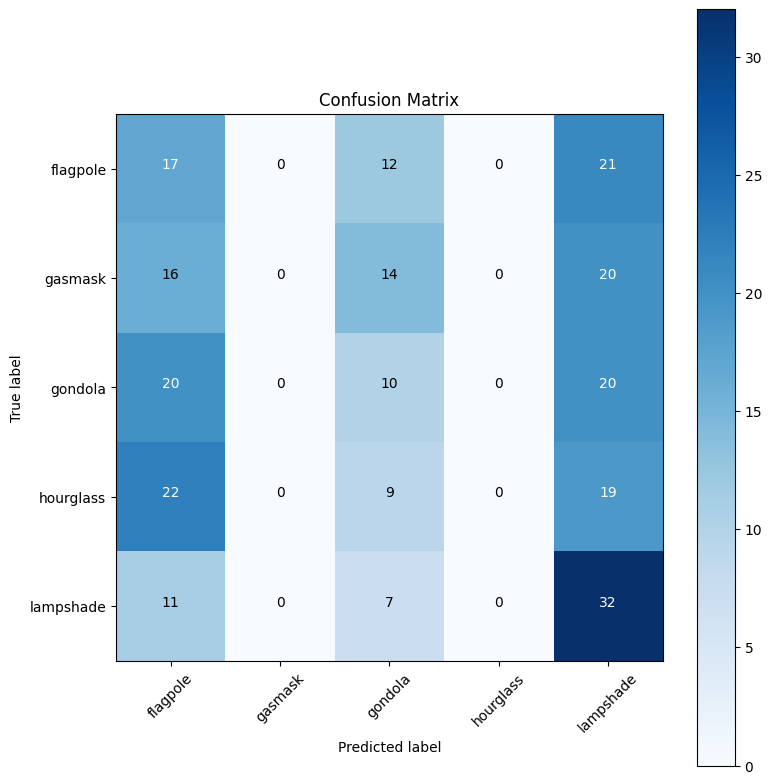

In [ ]:
import itertools
predictions00 = new_model0.predict(test_ds)
predicted_labels00 = np.argmax(predictions00, axis=1)
true_labels00 = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx00 = confusion_matrix(true_labels00, predicted_labels00)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx00, class_names)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_labels00, predicted_labels00, target_names=['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

    flagpole       0.20      0.34      0.25        50
     gasmask       0.00      0.00      0.00        50
     gondola       0.19      0.20      0.20        50
   hourglass       0.00      0.00      0.00        50
   lampshade       0.29      0.64      0.40        50

    accuracy                           0.24       250
   macro avg       0.14      0.24      0.17       250
weighted avg       0.14      0.24      0.17       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx00.shape[0]):
    tp = confusion_mtx00[class_label, class_label]
    fn = np.sum(confusion_mtx00[class_label, :]) - tp
    fp = np.sum(confusion_mtx00[:, class_label]) - tp
    tn = np.sum(confusion_mtx00) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx00.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.23600000000000004
Specificity (Average): 0.8089999999999999
PPV (Positive Predictive Value) (Average): nan
NPV (Negative Predictive Value) (Average): 0.8132651006351962


<ipython-input-24-131a571f201d>:16: RuntimeWarning: invalid value encountered in long_scalars
  ppv = tp / (tp + fp)


In [ ]:
history.history.keys()
history.history

{'loss': [6.647578716278076,
  1.6117478609085083,
  1.5529425144195557,
  1.444665551185608,
  1.4131354093551636,
  1.3872636556625366,
  1.4243749380111694,
  1.3317972421646118,
  1.3406562805175781,
  1.28255295753479,
  1.276743769645691,
  1.2967156171798706,
  1.2756022214889526,
  1.2556943893432617,
  1.2920063734054565,
  1.2881971597671509,
  1.2687571048736572,
  1.4920674562454224,
  1.4551879167556763,
  1.4335100650787354,
  1.4217126369476318,
  1.4294238090515137,
  1.3880678415298462,
  1.363308072090149,
  1.4283579587936401,
  1.3642083406448364,
  1.394882321357727,
  1.4089828729629517,
  1.4693444967269897,
  1.3978837728500366,
  1.3943876028060913,
  1.515483021736145,
  1.582410454750061,
  1.582581877708435,
  1.5855242013931274,
  1.5824990272521973,
  1.5837206840515137,
  1.5854262113571167,
  1.5836538076400757,
  1.6679577827453613,
  1.5832337141036987,
  1.584984302520752,
  1.5815614461898804,
  1.5776116847991943,
  1.5794906616210938,
  1.585803508

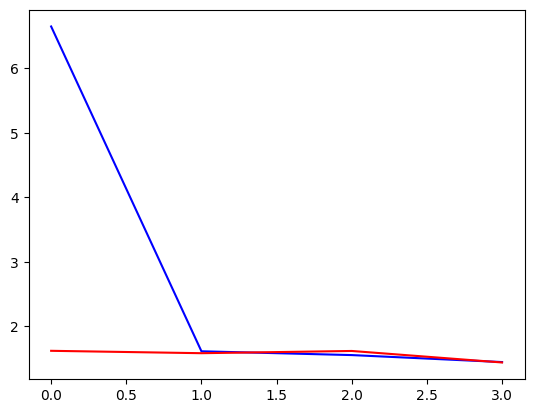

In [ ]:
plt.plot(range(4), history.history["loss"][:4], 'b')
plt.plot(range(4), history.history["val_loss"][:4], 'r')
plt.show()

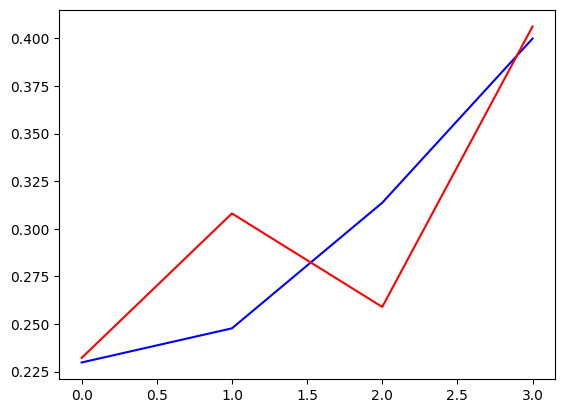

In [ ]:
plt.plot(range(4), history.history["accuracy"][:4], 'b')
plt.plot(range(4), history.history["val_accuracy"][:4], 'r')
plt.show()

# **ResNet-50**

In [ ]:
save_dir = '/content/drive/MyDrive/CSE428 Lab Project/Model1'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)

In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model,load_model
import itertools

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the Residual Block
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut connection if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define the ResNet model
def build_resnet(input_shape, num_classes, num_blocks, num_filters):
    input_layer = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=(5, 5), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Building the residual blocks
    for i in range(3):
        stride = 1 if i == 0 else 2  # First block uses stride 1, the rest use stride 2
        x = residual_block(x, filters=num_filters, stride=stride)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

input_shape = (224, 224, 3)
num_classes = 5

num_blocks = 3
num_filters = 64

resnet_model = build_resnet(input_shape, num_classes, num_blocks, num_filters)

resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 112, 112, 64)         4864      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 112, 112, 64)         256       ['conv2d_14[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 re_lu_7 (ReLU)              (None, 112, 112, 64)         0         ['batch_normalization_9[

In [ ]:

resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history1 = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/70
54/54 [==============================] - 22s 243ms/step - loss: 1.2159 - accuracy: 0.5174 - val_loss: 5.9990 - val_accuracy: 0.2388


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/70
54/54 [==============================] - 15s 277ms/step - loss: 1.0922 - accuracy: 0.5712 - val_loss: 3.8418 - val_accuracy: 0.3237
Epoch 3/70
54/54 [==============================] - 13s 248ms/step - loss: 1.0663 - accuracy: 0.5845 - val_loss: 4.9864 - val_accuracy: 0.2388
Epoch 4/70
54/54 [==============================] - 13s 240ms/step - loss: 1.0280 - accuracy: 0.5966 - val_loss: 7.5438 - val_accuracy: 0.3080
Epoch 5/70
54/54 [==============================] - 13s 244ms/step - loss: 0.9983 - accuracy: 0.6019 - val_loss: 8.4206 - val_accuracy: 0.2656
Epoch 6/70
54/54 [==============================] - 13s 250ms/step - loss: 1.0089 - accuracy: 0.6071 - val_loss: 3.2236 - val_accuracy: 0.2857
Epoch 7/70
54/54 [==============================] - 13s 246ms/step - loss: 0.9742 - accuracy: 0.6285 - val_loss: 2.2105 - val_accuracy: 0.4085
Epoch 8/70
54/54 [==============================] - 13s 245ms/step - loss: 0.9610 - accuracy: 0.6128 - val_loss: 1.8469 - val_accuracy: 0.3951

In [ ]:
import tensorflow as tf

# Provide the full path to your model file
file_path = "/content/drive/MyDrive/CSE428 Lab Project/Model1/checkpoint-62-0.82.h5"

# Try to load the model
try:
    new_model2 = tf.keras.models.load_model(file_path)
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading the model:", e)

Model loaded successfully!


In [ ]:
#scores = history.evaluate(test_ds)
test_loss, test_accuracy = resnet_model.evaluate(test_ds)

8/8 [==============================] - 0s 24ms/step - loss: 1.8019 - accuracy: 0.5360


8/8 [==============================] - 0s 20ms/step


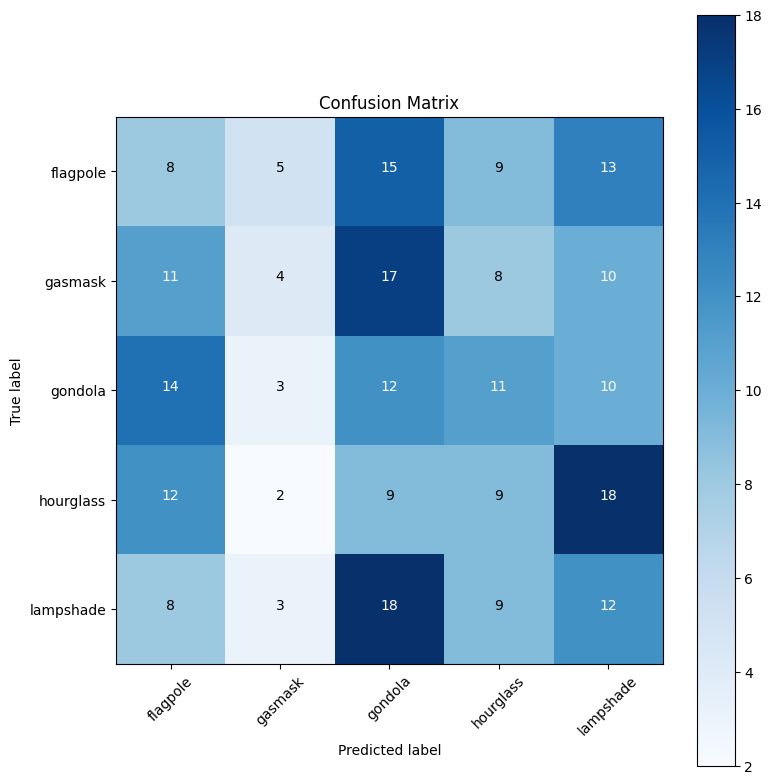

In [ ]:
predictions0 = new_model2.predict(test_ds)
predicted_labels0 = np.argmax(predictions0, axis=1)
true_labels0 = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx0 = confusion_matrix(true_labels0, predicted_labels0)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx0, class_names)
plt.show()

In [ ]:

from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_labels0, predicted_labels0, target_names=['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

    flagpole       0.15      0.16      0.16        50
     gasmask       0.24      0.08      0.12        50
     gondola       0.17      0.24      0.20        50
   hourglass       0.20      0.18      0.19        50
   lampshade       0.19      0.24      0.21        50

    accuracy                           0.18       250
   macro avg       0.19      0.18      0.17       250
weighted avg       0.19      0.18      0.17       250



In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx0.shape[0]):
    tp = confusion_mtx0[class_label, class_label]
    fn = np.sum(confusion_mtx0[class_label, :]) - tp
    fp = np.sum(confusion_mtx0[:, class_label]) - tp
    tn = np.sum(confusion_mtx0) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx0.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.18
Specificity (Average): 0.795
PPV (Positive Predictive Value) (Average): 0.18827599255395003
NPV (Negative Predictive Value) (Average): 0.7945795373306197


In [ ]:
"""show={}
show['Resnet50'] = scores[1]
     """

"show={}\nshow['Resnet50'] = scores[1]\n     "

In [ ]:
history1.history.keys()
history1.history

{'loss': [1.2158507108688354,
  1.0921753644943237,
  1.066304326057434,
  1.0280466079711914,
  0.9982901811599731,
  1.0088646411895752,
  0.9742235541343689,
  0.9610210061073303,
  0.9367461800575256,
  0.9320008158683777,
  0.9435067772865295,
  0.9187979698181152,
  0.9080612659454346,
  0.8944857120513916,
  0.8706825375556946,
  0.884218692779541,
  0.8657200336456299,
  0.873405396938324,
  0.8597530722618103,
  0.8524196743965149,
  0.8304114937782288,
  0.8207637071609497,
  0.8252522945404053,
  0.8187928199768066,
  0.8060343861579895,
  0.8002728223800659,
  0.8114139437675476,
  0.7953477501869202,
  0.8057380318641663,
  0.7935997247695923,
  0.7539452910423279,
  0.7744491696357727,
  0.7686336040496826,
  0.7497543692588806,
  0.7452170252799988,
  0.739595890045166,
  0.7383373379707336,
  0.7396292090415955,
  0.7291932702064514,
  0.7094986438751221,
  0.7190463542938232,
  0.6945239305496216,
  0.6997830867767334,
  0.6873242259025574,
  0.6647831201553345,
  0.67

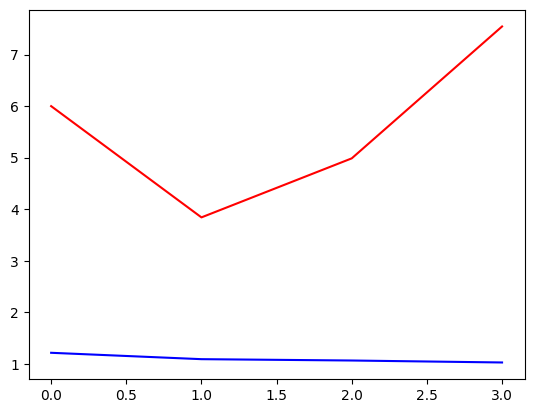

In [ ]:
plt.plot(range(4), history1.history["loss"][:4], 'b')
plt.plot(range(4), history1.history["val_loss"][:4], 'r')
plt.show()

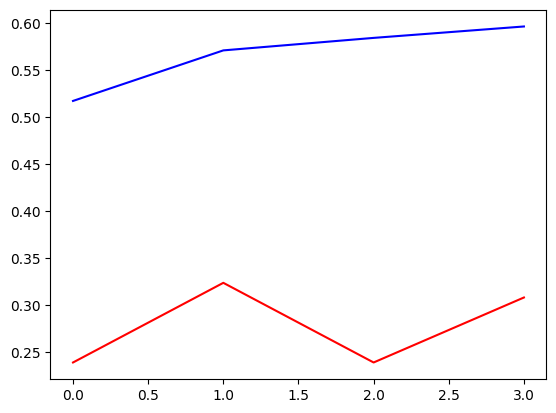

In [ ]:
plt.plot(range(4), history1.history["accuracy"][:4], 'b')
plt.plot(range(4), history1.history["val_accuracy"][:4], 'r')
plt.show()

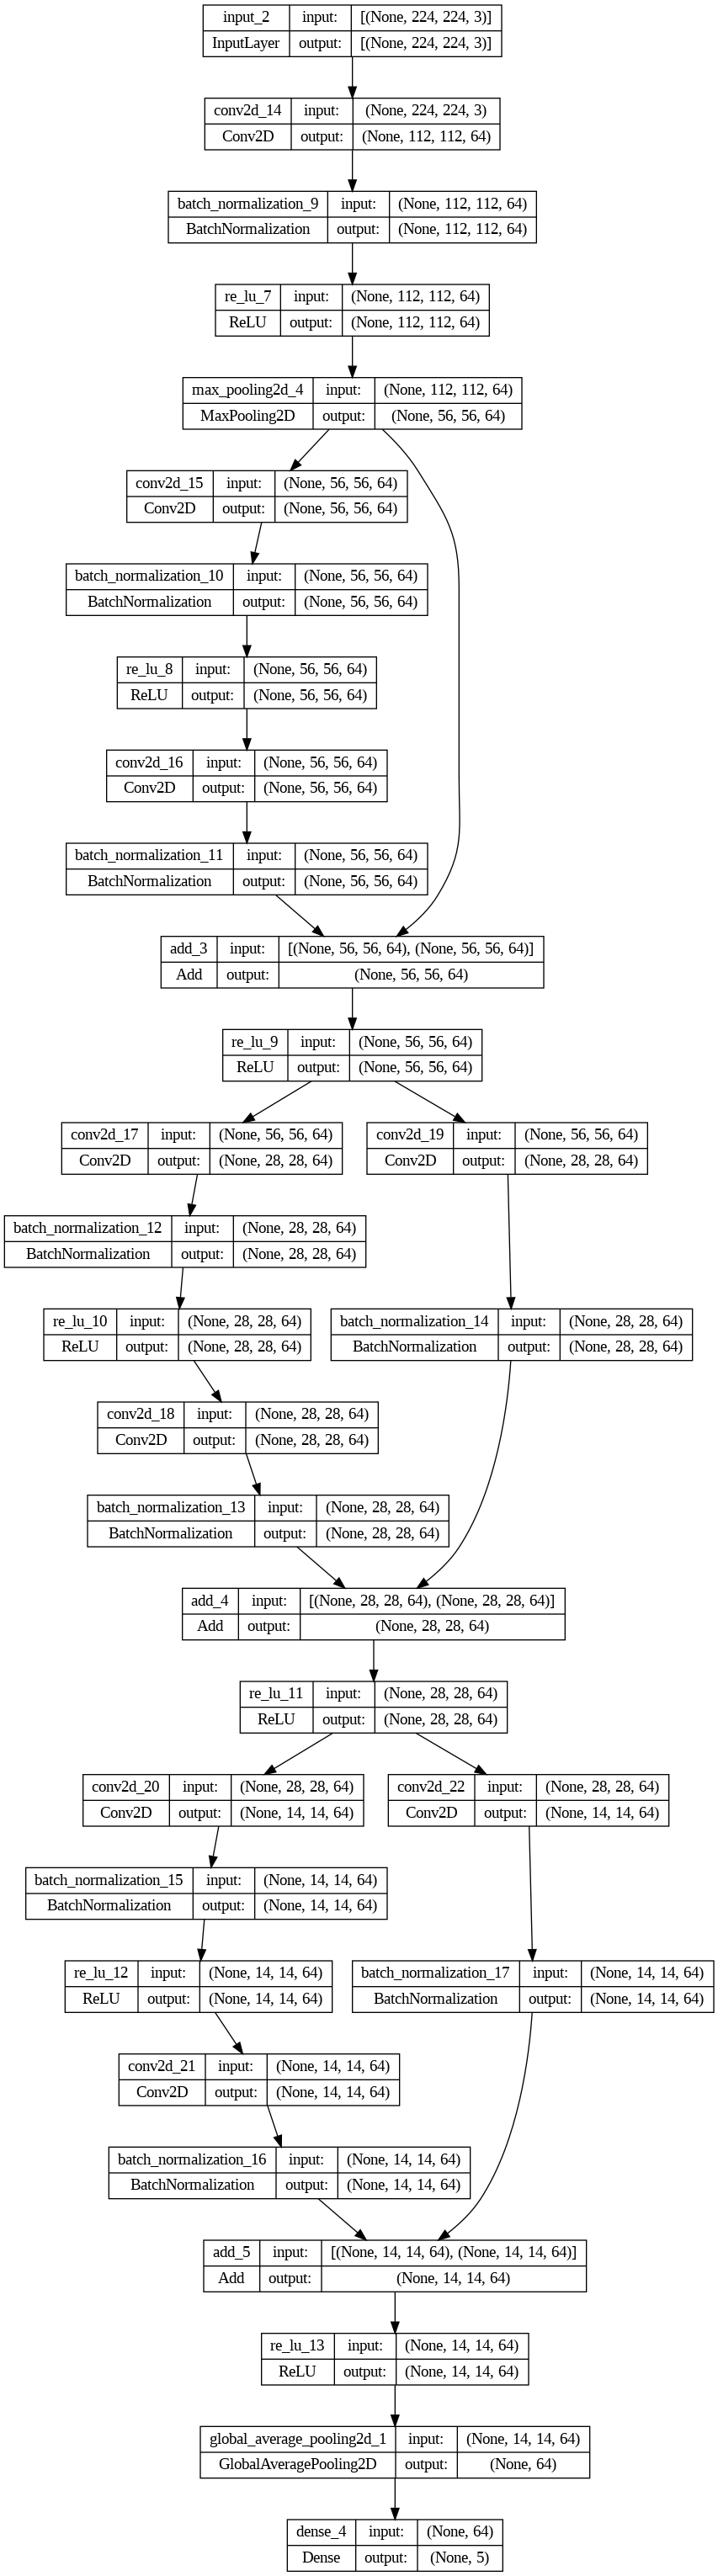

In [ ]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

# **Inception Net**

In [ ]:
save_dir = '/content/drive/MyDrive/CSE428 Lab Project/Model2'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
# Define a custom Inception-like block
def inception_block(x, filters):
    # 1x1 Convolution
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 Convolution followed by 5x5 Convolution
    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 Max Pooling followed by 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all branches
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])
    return output

# Define the custom InceptionNet model
def build_inception_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build the custom inception-like blocks
    x = inception_block(x, [64, 128, 128, 32, 32, 32])
    x = inception_block(x, [128, 192, 192, 96, 96, 64])

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build the custom InceptionNet model
inception_model = build_inception_net(input_shape, num_classes)

# Display model summary
inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 112, 112, 64)         9472      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_37[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 56, 56, 128)          8320      ['max_pooling2d_9[0][0]'

In [ ]:
inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history2 = inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 387.2205 - accuracy: 0.3461

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 53s 750ms/step - loss: 387.2205 - accuracy: 0.3461 - val_loss: 1.4562 - val_accuracy: 0.3527
Epoch 2/50
54/54 [==============================] - 47s 874ms/step - loss: 1.4152 - accuracy: 0.4201 - val_loss: 1.3409 - val_accuracy: 0.4420
Epoch 3/50
54/54 [==============================] - 19s 353ms/step - loss: 1.3297 - accuracy: 0.4774 - val_loss: 1.4987 - val_accuracy: 0.3415
Epoch 4/50
54/54 [==============================] - 18s 329ms/step - loss: 1.3197 - accuracy: 0.4716 - val_loss: 1.4104 - val_accuracy: 0.4018
Epoch 5/50
54/54 [==============================] - 32s 605ms/step - loss: 1.2664 - accuracy: 0.4936 - val_loss: 1.2287 - val_accuracy: 0.5112
Epoch 6/50
54/54 [==============================] - 45s 850ms/step - loss: 1.2345 - accuracy: 0.5150 - val_loss: 1.1843 - val_accuracy: 0.5246
Epoch 7/50
54/54 [==============================] - 53s 989ms/step - loss: 1.2166 - accuracy: 0.5208 - val_loss: 1.1768 - val_accuracy: 0.5402
Epoch 8/

In [ ]:
new_model3=tf.keras.models.load_model("/content/drive/MyDrive/CSE428 Lab Project/Model2/checkpoint-50-0.95.h5")

In [ ]:
scores = new_model3.evaluate(test_ds)

8/8 [==============================] - 1s 53ms/step - loss: 1.3105 - accuracy: 0.5240


In [ ]:
predictions = new_model3.predict(test_ds)

8/8 [==============================] - 1s 55ms/step


In [ ]:
import numpy as np

predicted_labels2 = np.argmax(predictions, axis=1)

In [ ]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_mtx = confusion_matrix(true_labels, predicted_labels2)

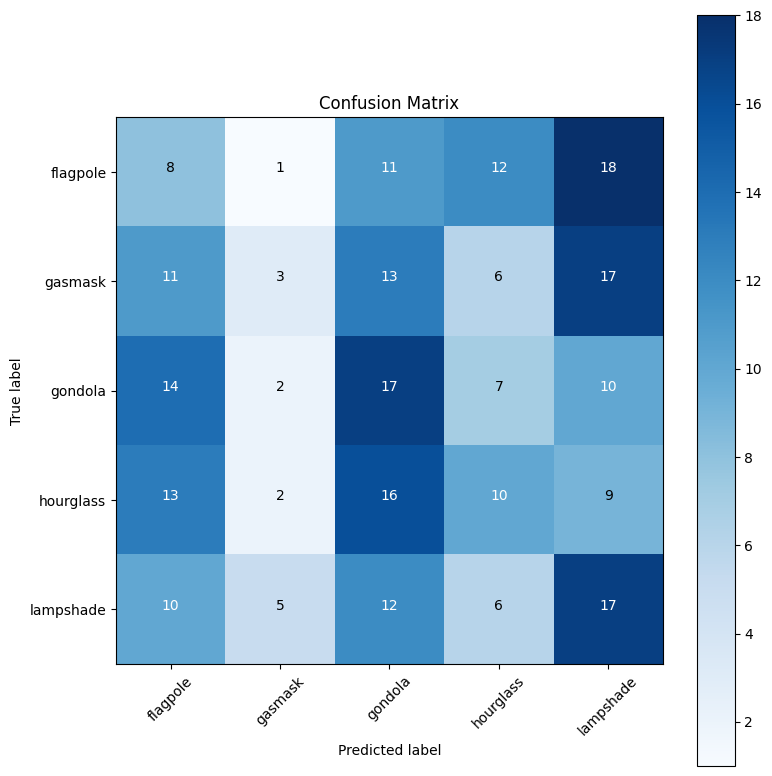

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['flagpole', 'gasmask', 'gondola', 'hourglass', 'lampshade']
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, class_names)
plt.show()

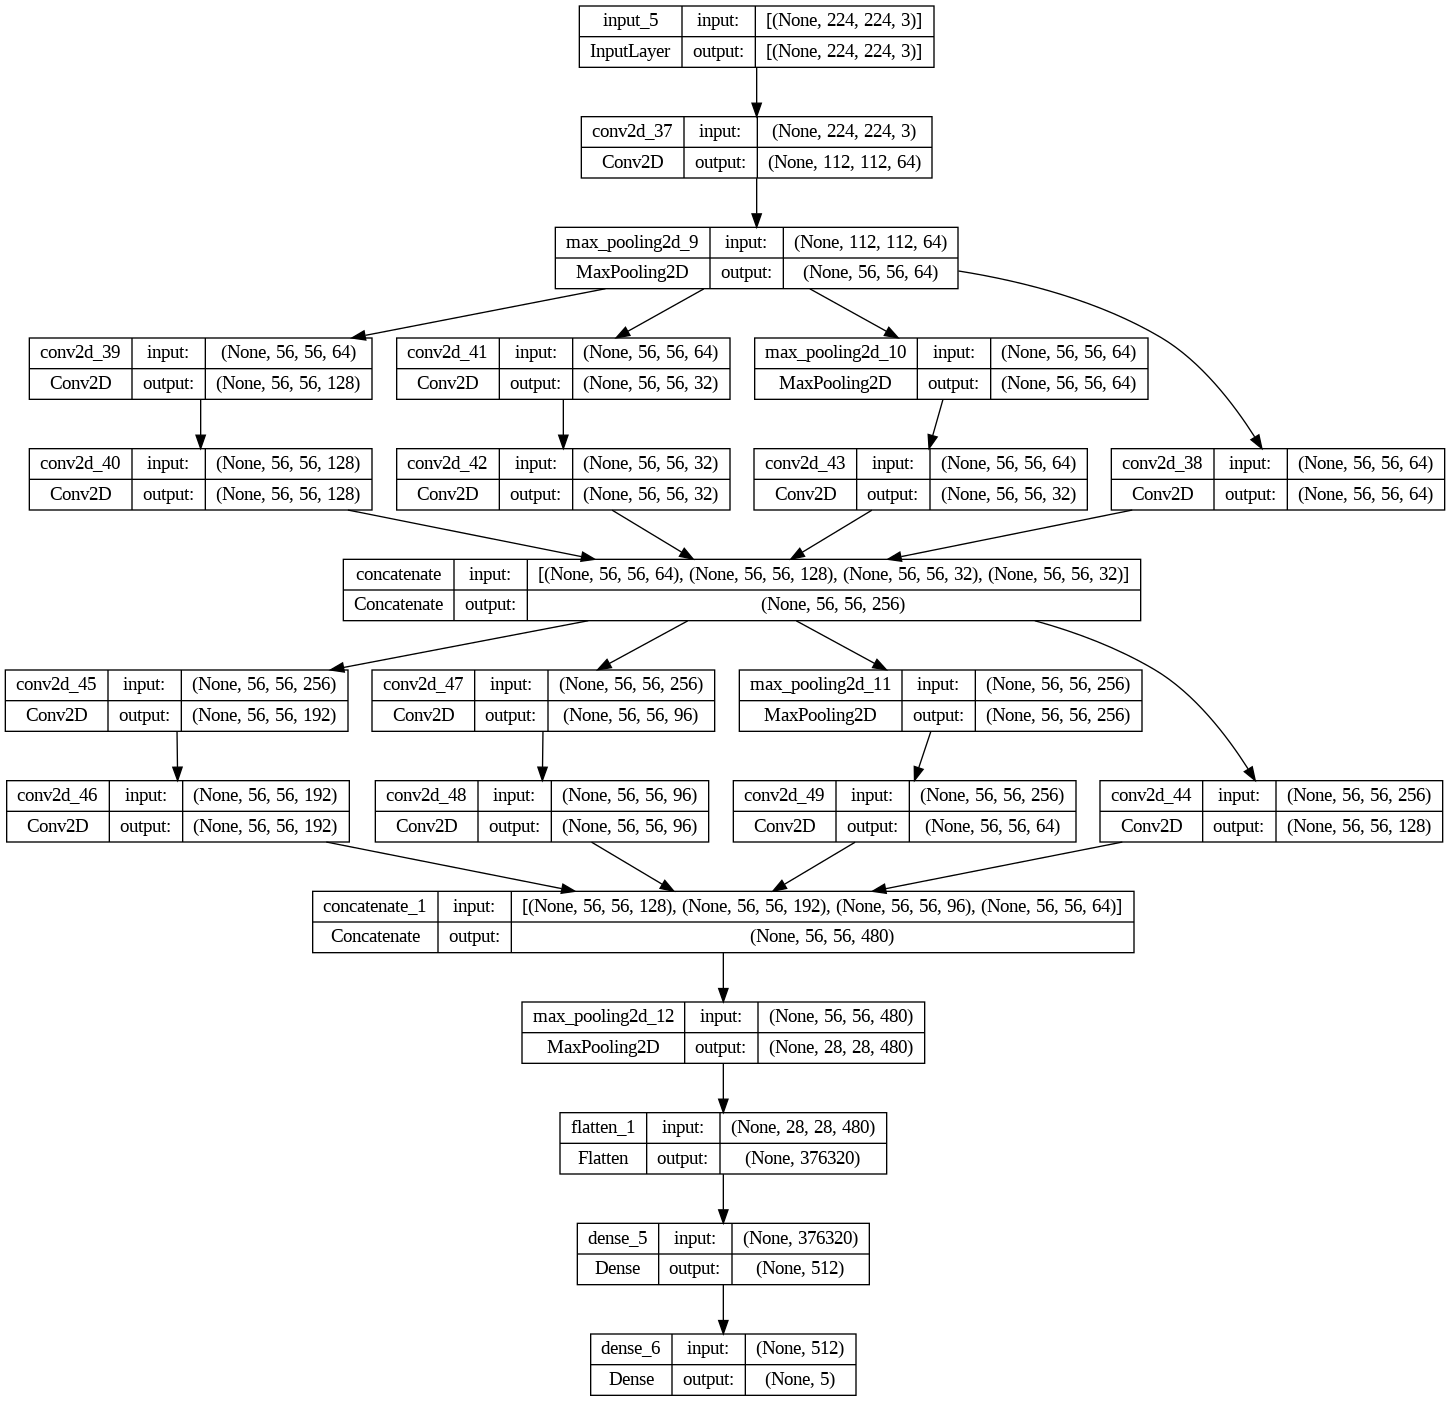

In [ ]:
tf.keras.utils.plot_model(inception_model, show_shapes=True)

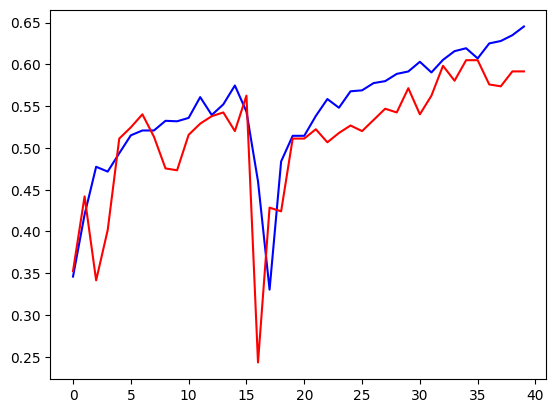

In [ ]:
plt.plot(range(40), history2.history["accuracy"][:40], 'b')
plt.plot(range(40), history2.history["val_accuracy"][:40], 'r')
plt.show()

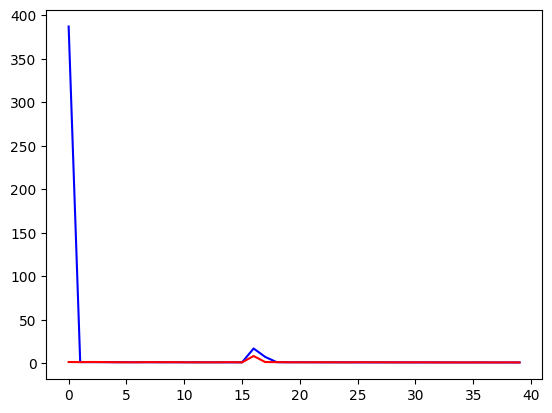

In [ ]:
plt.plot(range(40), history2.history["loss"][:40], 'b')
plt.plot(range(40), history2.history["val_loss"][:40], 'r')
plt.show()

# **Custom Model**

In [ ]:
save_dir = '/content/drive/MyDrive/CSE428 Lab Project/Model3/'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Define a custom Inception-like block with more flexibility
def custom_inception_block(x, filters):
    branch_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch_3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch_3x3)

    branch_5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch_5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return output

# Define a custom InceptionNet model with additional customization
def build_custom_inception_net(input_shape, num_classes, num_blocks=2, num_filters_per_block=None):
    if num_filters_per_block is None:
        num_filters_per_block = [[64, 128, 128, 32, 32, 32]] * num_blocks

    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build custom Inception-like blocks
    for filters in num_filters_per_block:
        x = custom_inception_block(x, filters)

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Customize the architecture by specifying num_blocks and num_filters_per_block
custom_inception_model = build_custom_inception_net(
    input_shape, num_classes, num_blocks=3, num_filters_per_block=[
        [64, 128, 128, 32, 32, 32],
        [128, 192, 192, 64, 64, 64],
        [192, 256, 256, 96, 96, 96]
    ])

# Display model summary
custom_inception_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 112, 112, 64)         9472      ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_18 (MaxPooli  (None, 56, 56, 64)           0         ['conv2d_69[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_71 (Conv2D)          (None, 56, 56, 128)          8320      ['max_pooling2d_18[0][0]

In [ ]:
custom_inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history3 =custom_inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/40
54/54 [==============================] - 29s 321ms/step - loss: 357.5638 - accuracy: 0.2425 - val_loss: 1.5490 - val_accuracy: 0.2969
Epoch 2/40
54/54 [==============================] - 18s 322ms/step - loss: 1.5444 - accuracy: 0.3171 - val_loss: 1.5865 - val_accuracy: 0.2812
Epoch 3/40
54/54 [==============================] - 18s 332ms/step - loss: 1.3864 - accuracy: 0.4167 - val_loss: 1.3552 - val_accuracy: 0.4152
Epoch 4/40
54/54 [==============================] - 19s 346ms/step - loss: 1.2574 - accuracy: 0.4769 - val_loss: 1.3052 - val_accuracy: 0.4442
Epoch 5/40
54/54 [==============================] - 17s 321ms/step - loss: 1.2275 - accuracy: 0.5041 - val_loss: 1.1908 - val_accuracy: 0.5246
Epoch 6/40
54/54 [==============================] - 18s 334ms/step - loss: 1.1936 - accuracy: 0.5156 - val_loss: 1.1381 - val_accuracy: 0.5357
Epoch 7/40
54/54 [==============================] - 17s 313ms/step - loss: 1.1816 - accuracy: 0.5260 - val_loss: 1.1563 - val_accuracy: 0.48

In [ ]:
new_model4=tf.keras.models.load_model("/content/drive/MyDrive/CSE428 Lab Project/Model3/checkpoint-45-1.34.h5")

In [ ]:
scores = new_model4.evaluate(test_ds)


8/8 [==============================] - 1s 28ms/step - loss: 1.1375 - accuracy: 0.5700


# **Predicting image**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


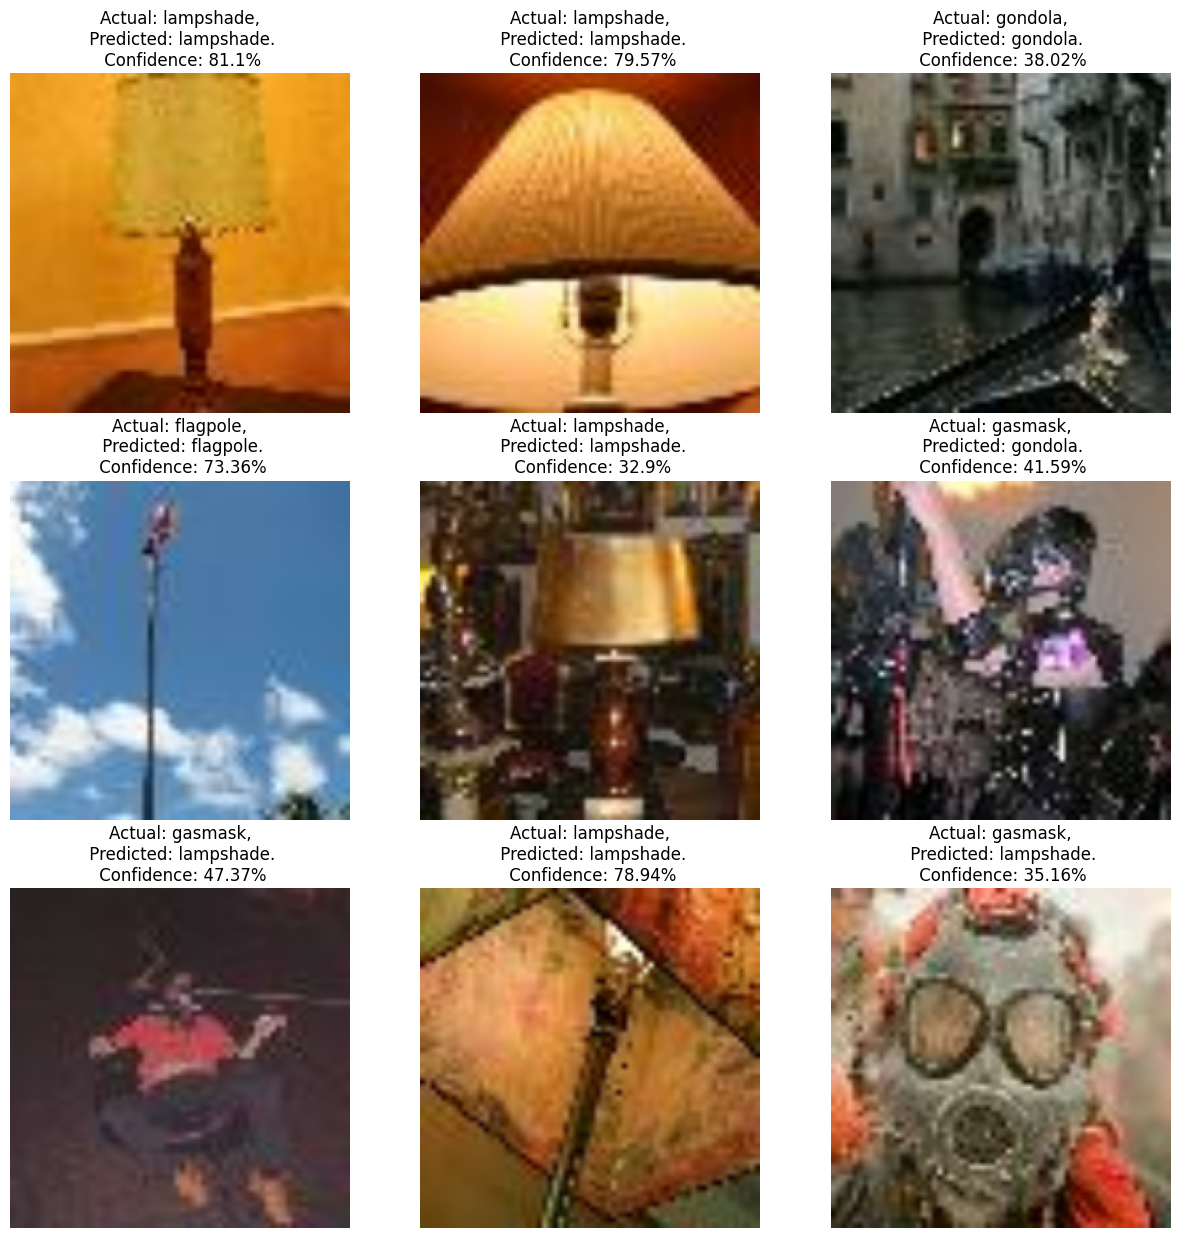

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model0, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 18ms/step


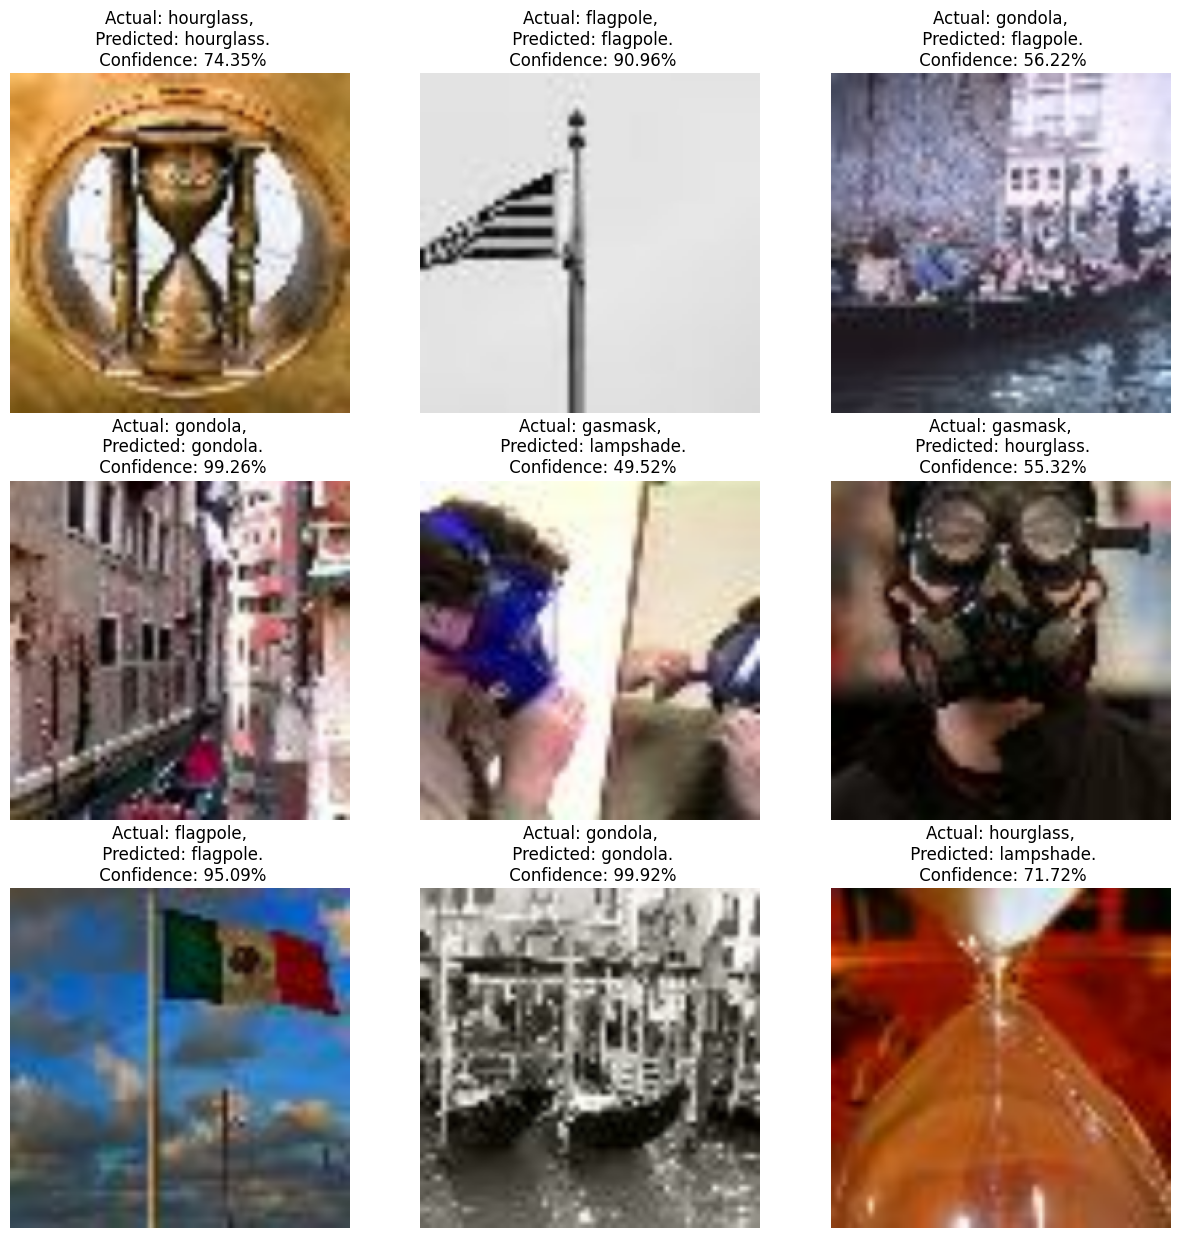

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model2, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 31ms/step


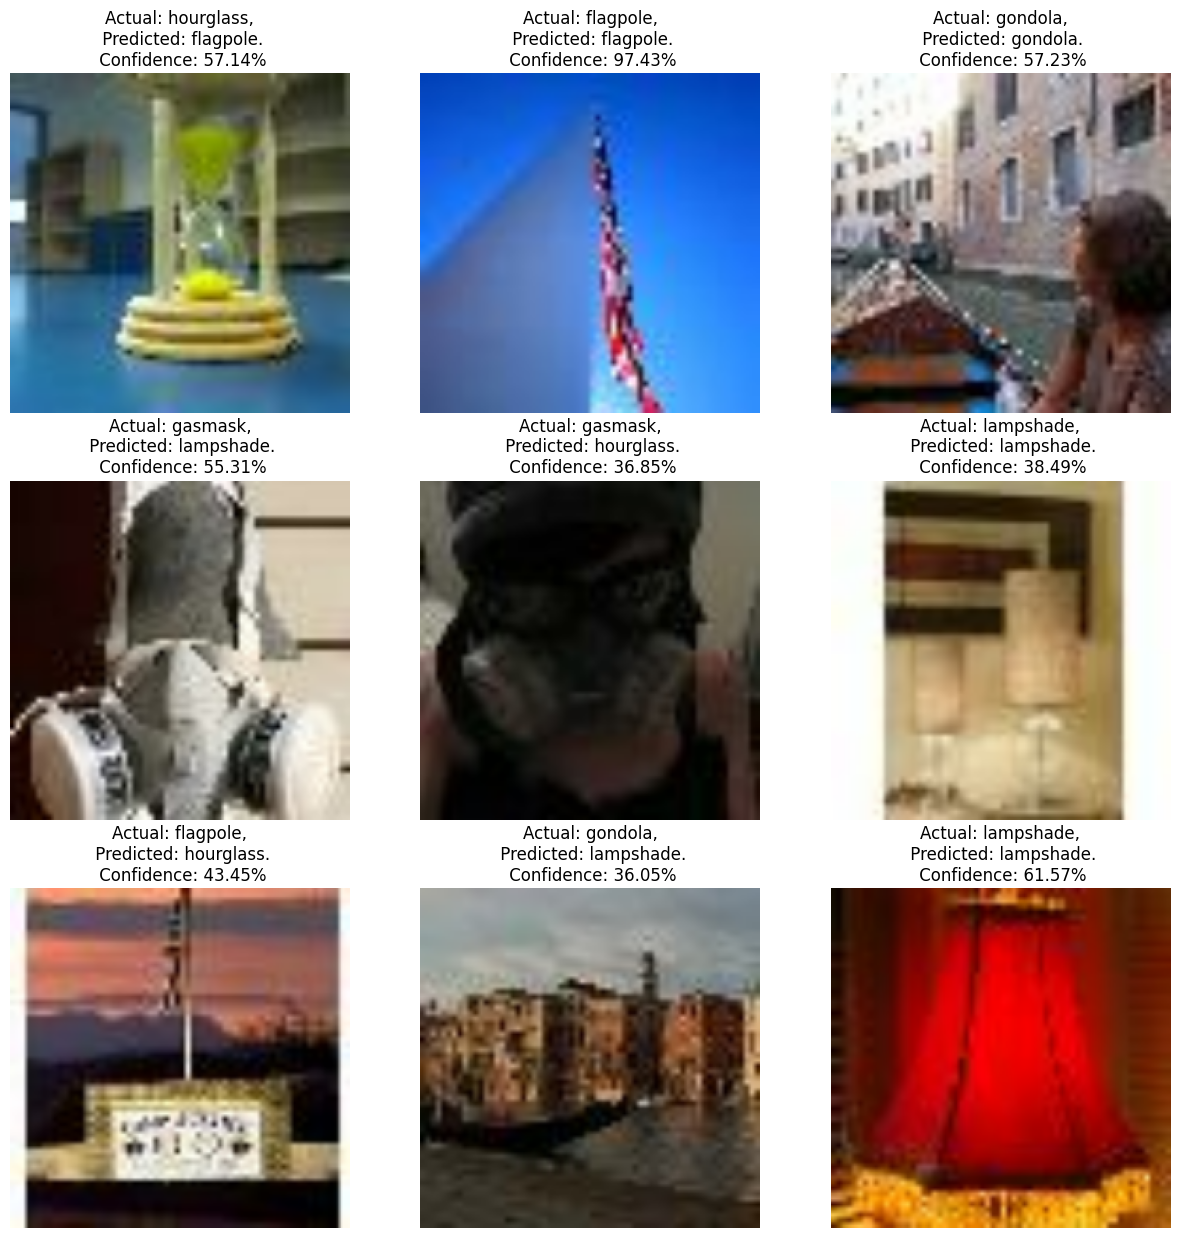

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model3, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# **Compare**


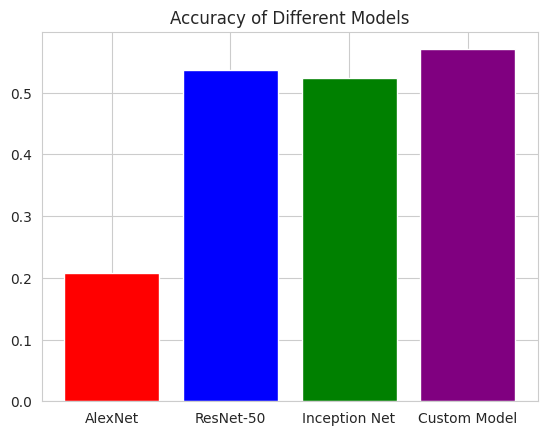

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['AlexNet', 'ResNet-50', 'Inception Net', 'Custom Model']

# Accuracy values
accuracy_values = [0.2080, 0.5360, 0.5240, 0.5700]


fig, ax = plt.subplots()
ax.bar(models, accuracy_values, color=['red', 'blue', 'green', 'purple'])
ax.set_title('Accuracy of Different Models')
plt.show()
